# LSTM Model Stock Price Prediction AMZN

## Imports 

In [160]:
from datetime import date, timedelta
import numpy as np
import pandas as pd
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [161]:
data = yf.download('AMZN', start=(date.today() - timedelta(days=5000)),
                   end=date.today().strftime("%Y-%m-%d"))
data["Date"] = data.index

[*********************100%%**********************]  1 of 1 completed


## Filter by Close Price

In [155]:
close_data = data.iloc[:,3:4]
close_data.head()
data_train = close_data[close_data.index < '2018-01-31'].copy()
data_train

,Close
Date,
2010-03-12,6.591000
2010-03-15,6.556500
2010-03-16,6.589500
2010-03-17,6.567000
2010-03-18,6.638000
...,...
2018-01-24,67.875504
2018-01-25,68.897499
2018-01-26,70.102501


In [156]:
data_testing = close_data[close_data.index >= '2018-01-31'].copy()
data_testing

,Close
Date,
2018-01-31,72.544502
2018-02-01,69.500000
2018-02-02,71.497498
2018-02-05,69.500000
2018-02-06,72.141998
...,...
2023-11-13,142.589996
2023-11-14,145.800003
2023-11-15,143.199997


In [157]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_train)

In [158]:
x_train = []
y_train = []
for i in range(100, data_train.shape[0]):
    x_train.append(scaled_data[i - 100:i])
    y_train.append(scaled_data[i,0])


In [162]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [163]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1886, 100, 1)

## Building LSTM Model 


In [164]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(units = 64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [165]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 128)          66560     
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [166]:
import tensorflow as tf 

model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = [tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train, epochs = 5, batch_size = 64)

Epoch 1/5
30/30 [==============================] - 5s 116ms/step - loss: 0.0153 - mean_absolute_error: 0.0711
Epoch 2/5
30/30 [==============================] - 4s 118ms/step - loss: 4.4684e-04 - mean_absolute_error: 0.0153
Epoch 3/5
30/30 [==============================] - 5s 167ms/step - loss: 2.1751e-04 - mean_absolute_error: 0.0099
Epoch 4/5
30/30 [==============================] - 5s 182ms/step - loss: 2.1306e-04 - mean_absolute_error: 0.0097
Epoch 5/5
30/30 [==============================] - 4s 136ms/step - loss: 2.1124e-04 - mean_absolute_error: 0.0097


In [188]:
past_100 = data_train.tail(100)
past_100
dt = pd.concat([past_100,data_testing], ignore_index = True)
dt['Close'].max()
print(dt['Close'].max())
dt


186.57049560546875


,Close
0,48.973499
1,48.294998
2,48.897999
3,49.129002
4,49.980000
...,...
1556,142.589996
1557,145.800003
1558,143.199997
1559,142.830002


In [189]:
inputs = scaler.fit_transform(dt)

In [180]:
X_test = [] 
y_test = []
for i in range(100, inputs.shape[0]):
    X_test.append(inputs[i-100:i])
    y_test.append(inputs[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [181]:
y_pred = model.predict(X_test)

46/46 [==============================] - 1s 22ms/step


In [182]:
scale = 1/scaler.scale_[0]

In [183]:
y_pred = y_pred * scale
y_test = y_test*scale

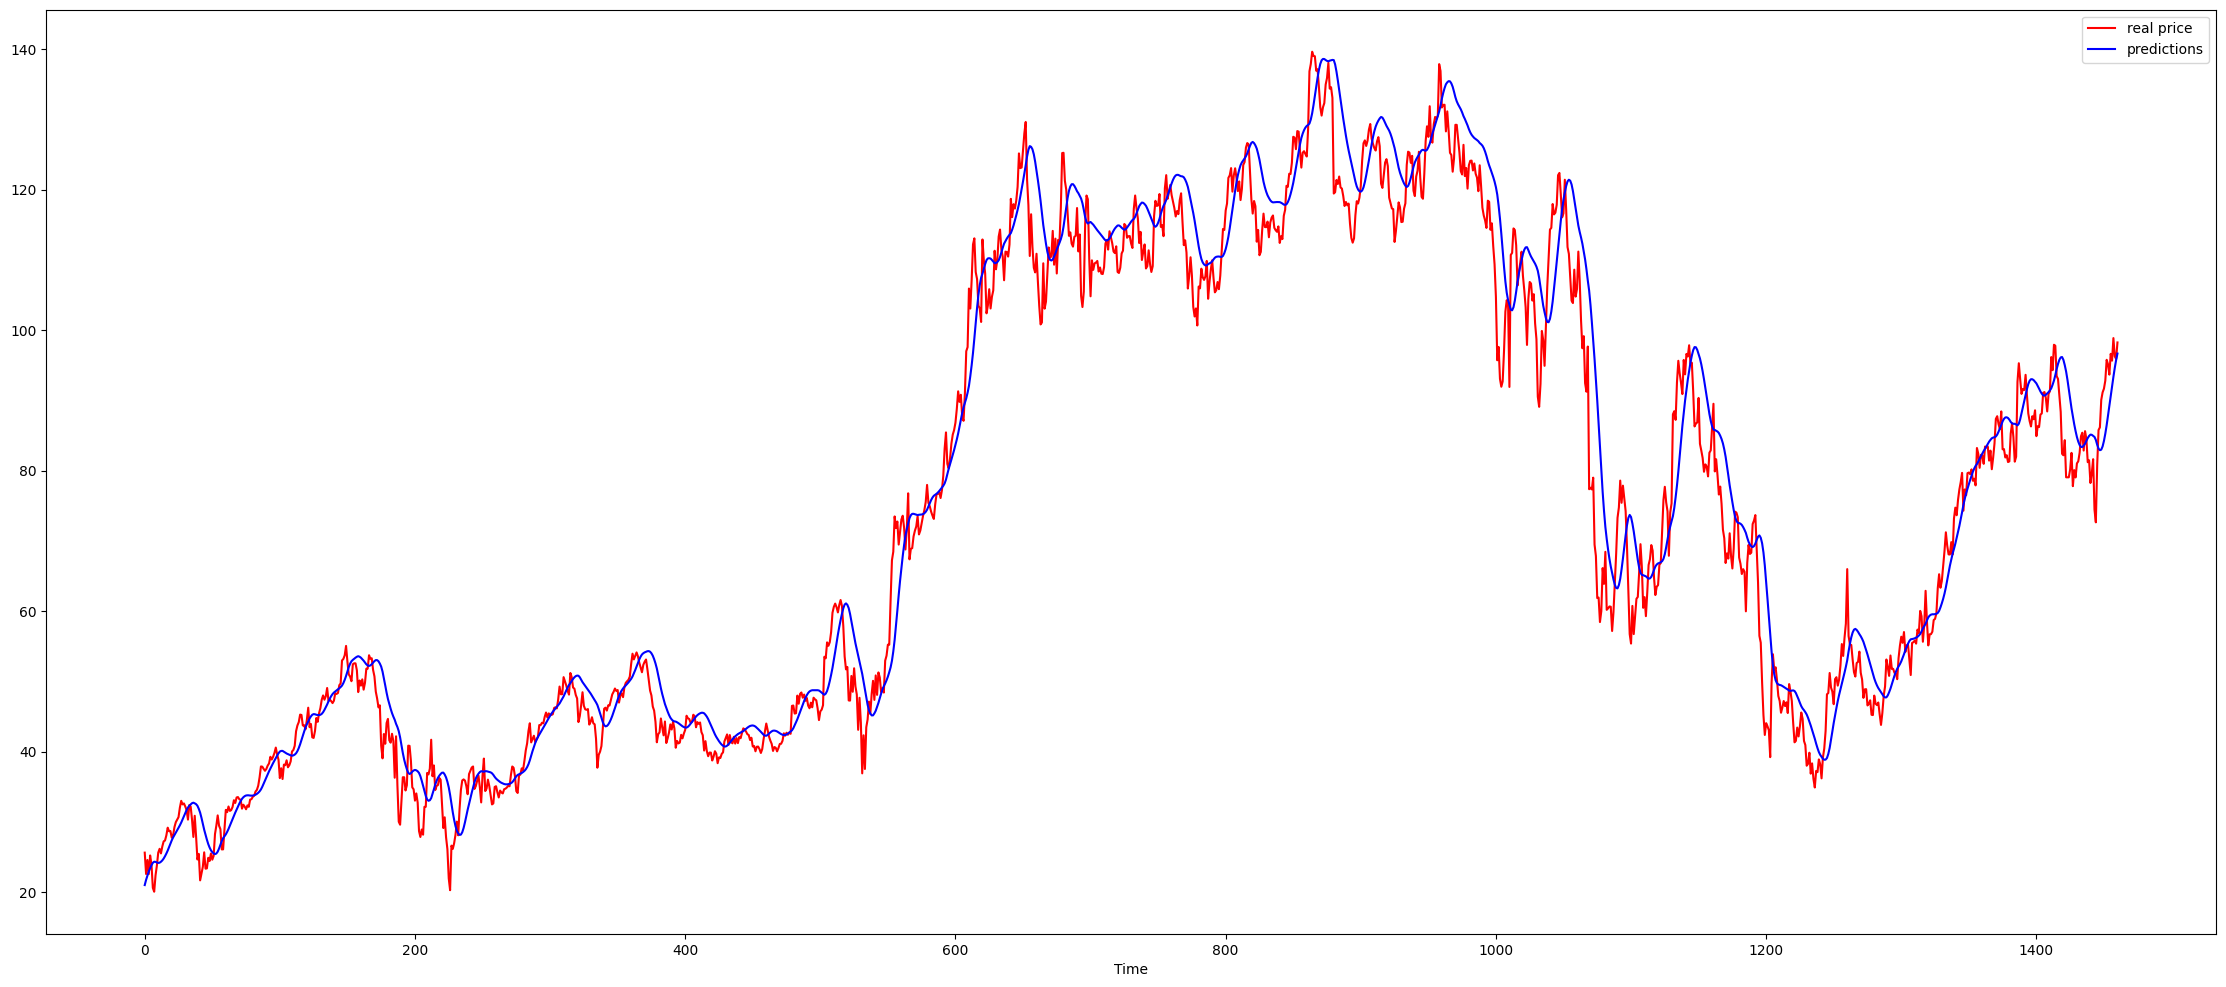

In [184]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'real price')
plt.plot(y_pred, color = 'blue', label = 'predictions')
plt.xlabel('Time')
plt.legend()
plt.show()